# Finetuned SAM2 Inference

In [1]:
# - packages
import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes

In [2]:
# - global variables
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'
sam2_checkpoint = "./sam2_hiera_large.pt"
model_cfg = "./sam2_hiera_l.yaml"
overlapp_ratio = 0.15

## Data and Prompt Preparation

In [3]:
# - Prepare Validation Dataset (raw image and segmentation)
data = []
for ff, name in enumerate(os.listdir(raw_image_dir)):
    data.append({'image': raw_image_dir / f'image{ff:04d}.png', 'annotation': seg_image_dir / f'seg{ff:04d}.png'})
# - split train dataset and validation dataset
valid_data = data[80:]

# - Prepare Test Raw Image
test_sample_path = test_image_dir / 'image0000.png'
test_sample_image = cv2.imread(str(test_sample_path))

In [4]:
# - Input Points Preparation
## - Validated Image Randomly Points within Masks
valid_image_path = valid_data[0]['image']
valid_mask_path = valid_data[0]['annotation']
def read_image(image_path, mask_path): # read and resize image and mask
        img = cv2.imread(str(image_path)) # read image as rgb
        mask = np.array(Image.open(mask_path)) # mask of the region we want to segment
        
        # Resize image to maximum size of 1024
        r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
        img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
        mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)),interpolation=cv2.INTER_NEAREST)
        return img, mask
valid_image,valid_mask = read_image(valid_image_path, valid_mask_path)
num_samples = 1000
def get_points(mask,num_points): # Sample points inside the input mask
        points=[]
        for i in range(num_points):
            coords = np.argwhere(mask > 0)
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([[yx[1], yx[0]]])
        return np.array(points)
valid_input_points = get_points(valid_mask,num_samples)
## - Test Image Randomly Points
num_samples = 500
def get_points(mask,num_points): # Sample points inside the input mask
        points=[]
        for i in range(num_points):
            coords = np.argwhere(mask > 0)
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([[yx[1], yx[0]]])
        return np.array(points)
test_input_points = get_points(test_sample_image[:, :, 0],num_samples)

In [5]:
# - Bounding Box Preparation
def convert_mask2box(mask:np.ndarray):
    inds = np.unique(mask)[1:] # load all indices

    masks = [] 
    for ind in inds:
        masks.append(mask == ind)

    masks = np.array(masks)
    masks_tensor = torch.from_numpy(masks)

    boxes = masks_to_boxes(masks_tensor)
    valid_input_boxes = boxes.numpy()
    return valid_input_boxes

valid_input_boxes = convert_mask2box(valid_mask)

In [6]:
# - Bounding Box + Points
valid_input_points_lst = []
for i in range(10):
    valid_input_points_lst.append(np.array([[np.random.uniform(box[0], box[2]), np.random.uniform(box[1], box[3])] for box in valid_input_boxes]))    
valid_input_points_lst = np.array(valid_input_points_lst)
valid_input_points_lst = valid_input_points_lst.reshape(valid_input_points_lst.shape[0] * valid_input_points_lst.shape[1], 1, valid_input_points_lst.shape[2])

## Load Finetuned Model and Predict Image Segmentation

In [7]:
# - Load Parameters
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device='cpu')
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load("./checkpoints/large_model8163.torch"))


<All keys matched successfully>

In [8]:
def predict_seg(mode:str, img:np.ndarray, input_points: np.ndarray, point_labels: np.ndarray, input_boxes = None):
    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
    if mode == "points":
        with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
            predictor.set_image(img) # image encoder
            masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
                point_coords=input_points,
                point_labels=point_labels,
                multimask_output=False)
    elif mode == 'boxes':
        with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
            predictor.set_image(img) # image encoder
            masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
                point_coords=None,
                point_labels=None,
                multimask_output=False,
                box = input_boxes)
    else:
        print('Not Valid Mode')
        return None
            
    # - sort masks based on their scores (high-quality segmentation)
    masks=masks[:,0].astype(bool)
    shorted_masks = masks[np.argsort(scores[:,0])][::-1].astype(bool)
     # - create an empty segmentation map
    seg_map = np.zeros_like(shorted_masks[0],dtype=np.uint8)
    occupancy_mask = np.zeros_like(shorted_masks[0],dtype=bool)

    # - add the masks one by one from high to low score
    for i in range(shorted_masks.shape[0]):
        mask = shorted_masks[i]
        if (mask*occupancy_mask).sum()/mask.sum()>overlapp_ratio: continue 
        mask[occupancy_mask]=0
        seg_map[mask]=i+1
        occupancy_mask[mask]=1
        
    # - project back to RGB
    rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
    for id_class in range(1,seg_map.max()+1):
        rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    plt.figure(figsize=(20, 20))

    # First image (annotation)
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
    plt.imshow(rgb_image)
    plt.title('Annotation')
    plt.axis('off')  # Hide the axis

    # Second image (mix)
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
    mix_image = (rgb_image / 2 + img / 2).astype(np.uint8)
    plt.imshow(mix_image)
    plt.title('Mix')
    plt.axis('off')

    # Third image (original image)
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.tight_layout()  # Adjust the layout so everything fits without overlap
    plt.show()

### Points

/tmp/ipykernel_10822/1560564997.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  seg_map[mask]=i+1
/tmp/ipykernel_10822/1560564997.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 257 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  seg_map[mask]=i+1
/tmp/ipykernel_10822/1560564997.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 259 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  s

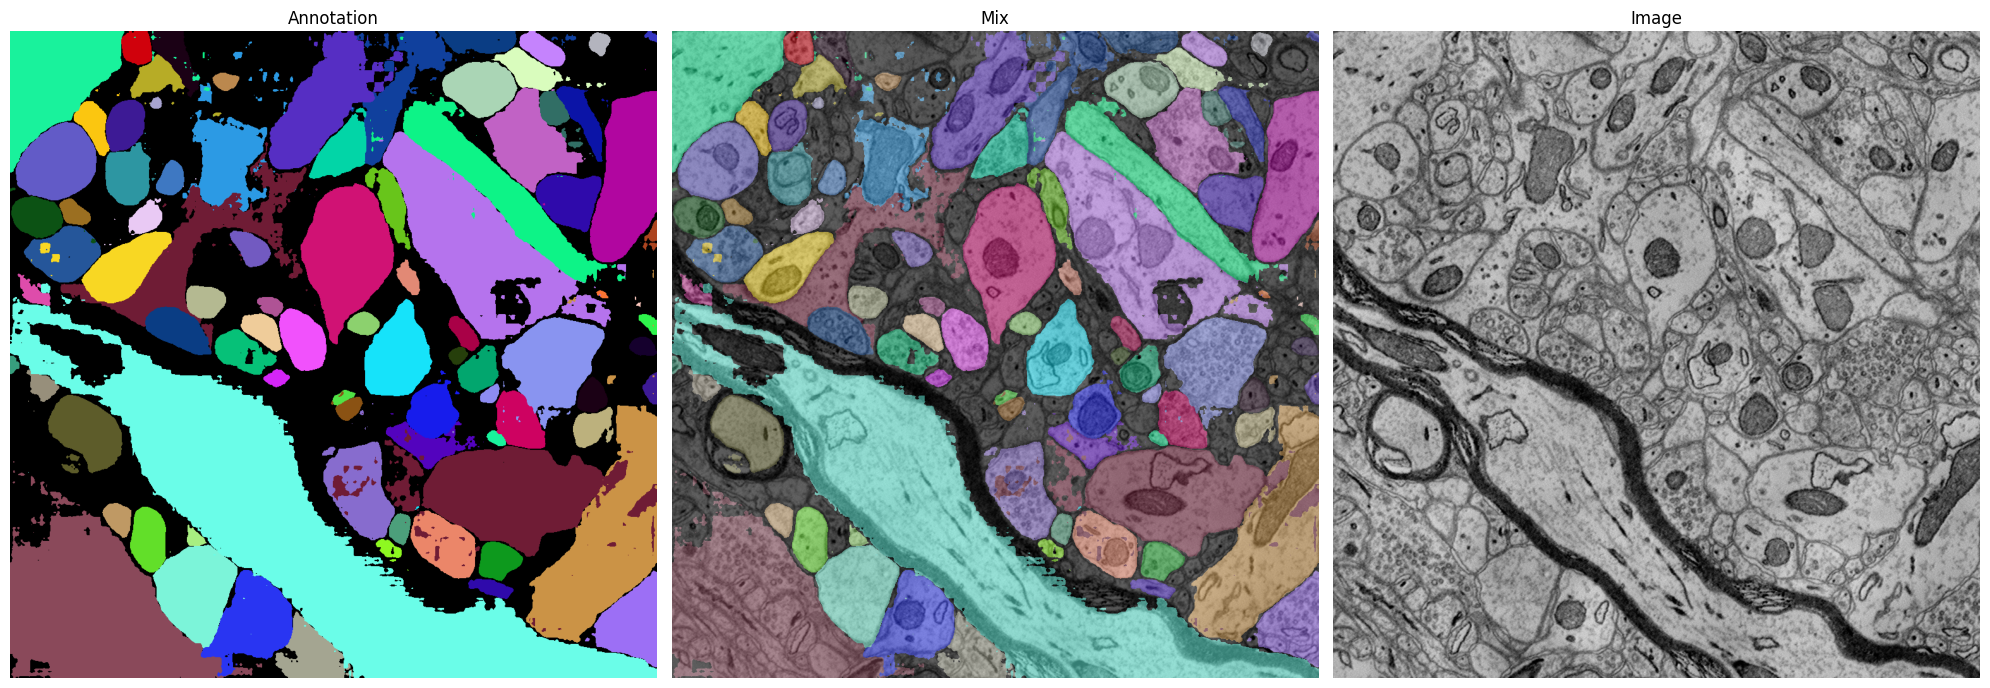

In [9]:
# - Predict Segmentation with Random Input Points of Test Sample Image
predict_seg('points', test_sample_image, test_input_points, np.ones([test_input_points.shape[0], 1]))


/tmp/ipykernel_10822/1560564997.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  seg_map[mask]=i+1
/tmp/ipykernel_10822/1560564997.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 278 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  seg_map[mask]=i+1
/tmp/ipykernel_10822/1560564997.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 281 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  s

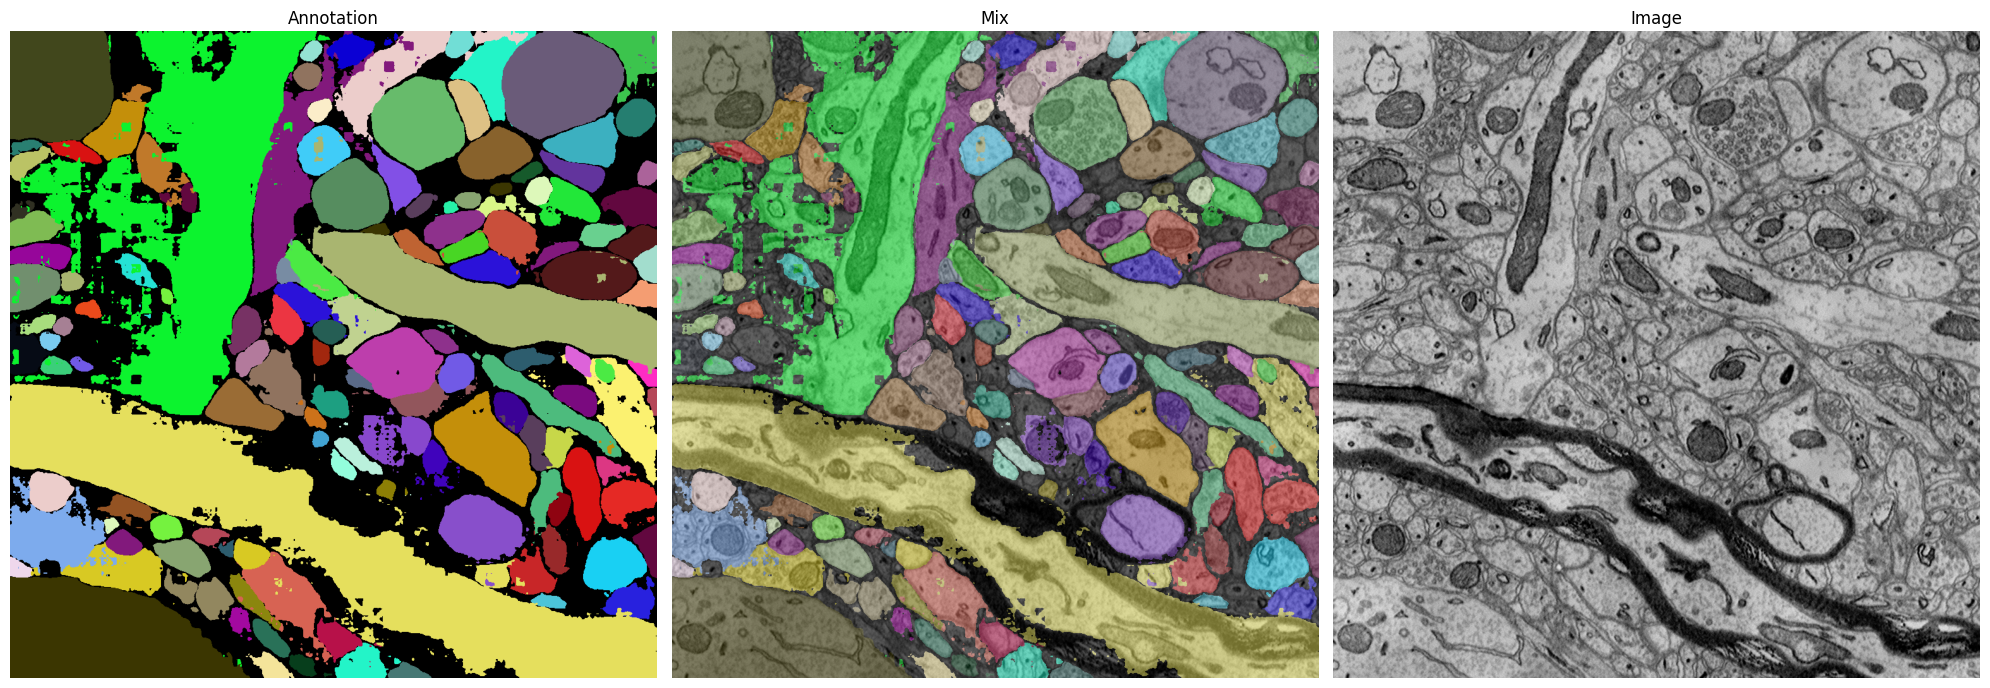

In [10]:
# - Predict Segmentation with mask Input Points of Valid Sample Image
predict_seg('points', valid_image, valid_input_points, np.ones([valid_input_points.shape[0], 1]))


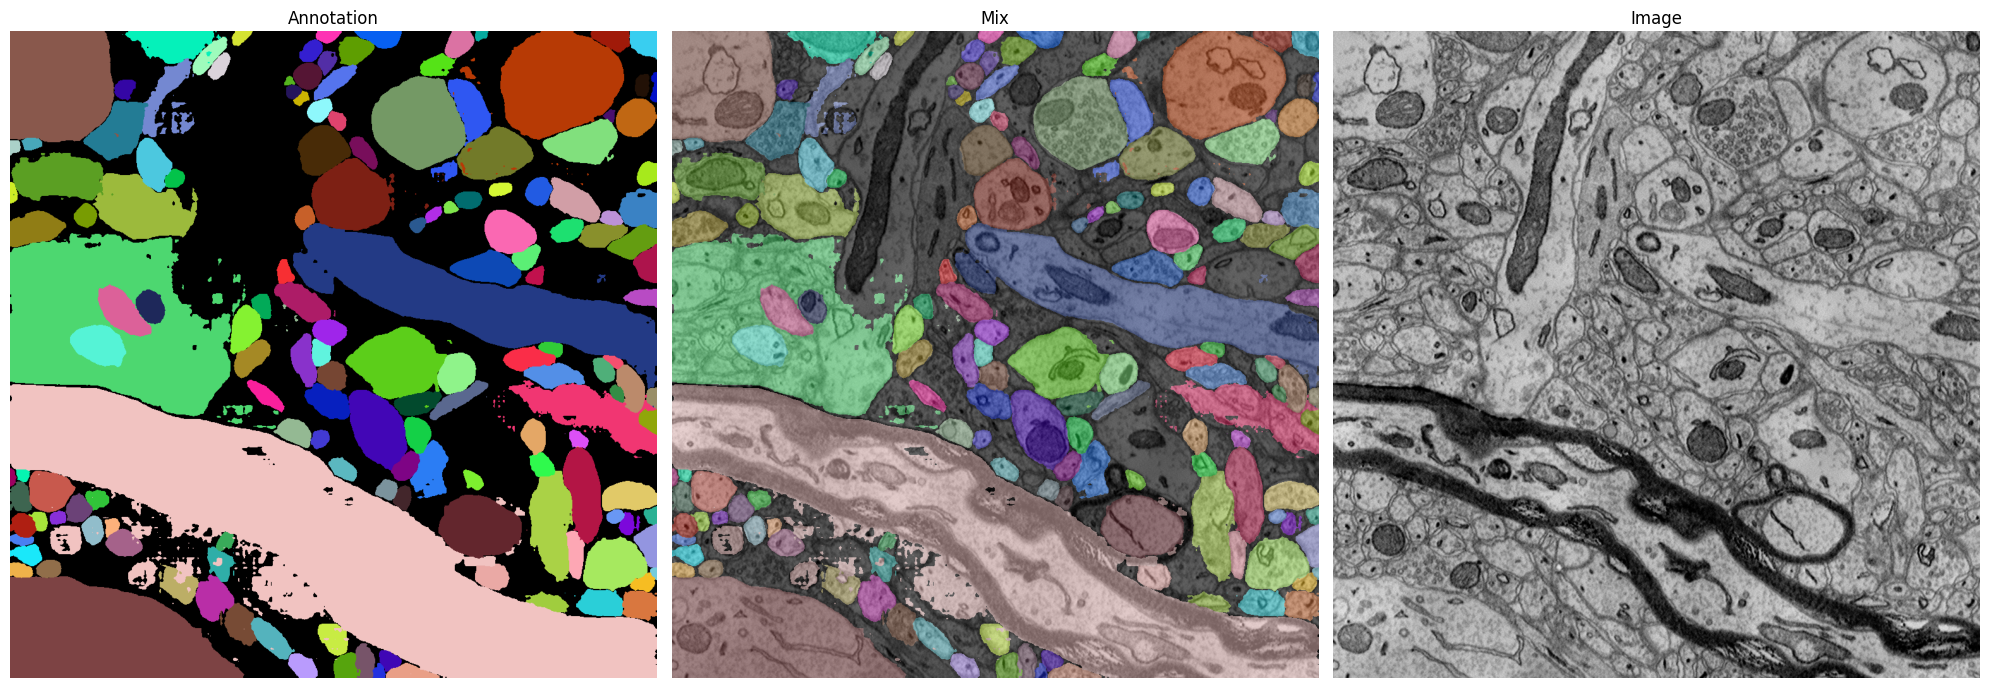

In [11]:
# - Predict Segmentation with Bounding boxes of Valid Sample Image
predict_seg('boxes', valid_image, None, None, valid_input_boxes)


/tmp/ipykernel_10822/1560564997.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 257 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  seg_map[mask]=i+1
/tmp/ipykernel_10822/1560564997.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 263 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  seg_map[mask]=i+1
/tmp/ipykernel_10822/1560564997.py:34: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 268 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  s

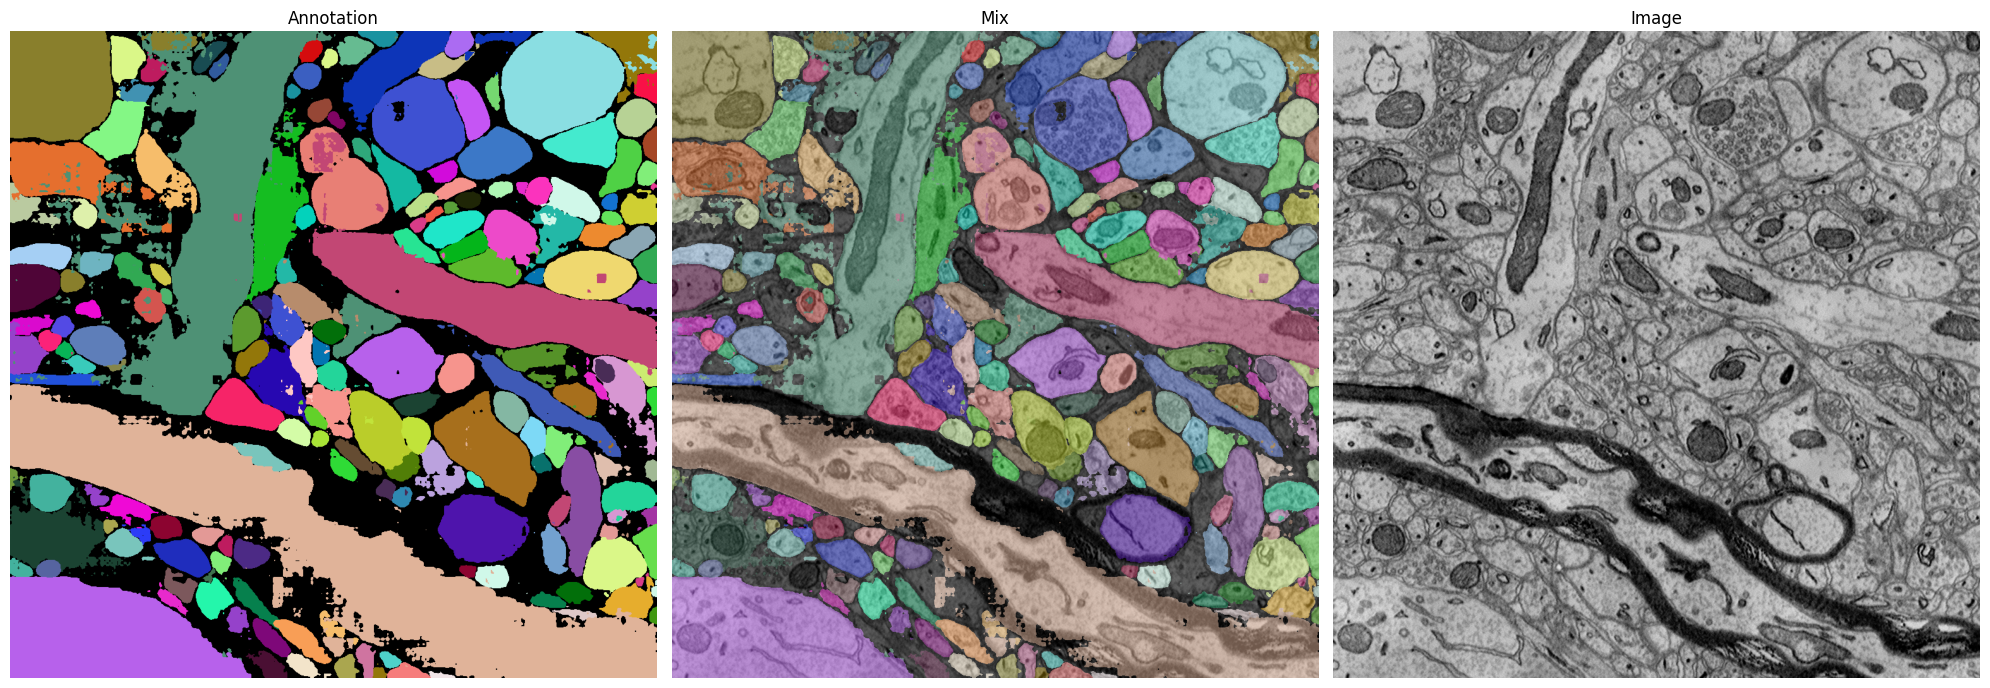

In [12]:
# - Predict Segmentation with Points within Bounding Boxes of Valid Sample Image
predict_seg('points', valid_image, valid_input_points_lst, np.ones([valid_input_points_lst.shape[0], 1]))